In [1]:
import pandas as pd
from numpy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as pl
from scipy.optimize import least_squares
from datetime import date, timedelta
import random
import math

## Import de dados

In [2]:
# Dados começam 01/01/2022
# Vacinação começa 19/01/2022
# fillna(0) substitui todos os valores sem input por 0
Dados = pd.read_csv ('../dados_usados/estado.csv')
DadosGrandes = pd.read_csv ('../dados_usados/Dados_novos_BAHIA.csv')
vacinados_dados = DadosGrandes['Vacinados'].fillna(0).values
mortos_dados = Dados['deaths'].fillna(0).values
casos_dados = Dados['cases'].fillna(0).values
datas = Dados["date"].fillna(0).values
Psi = pd.read_csv('../dados_usados/psi.csv')
# Pega a lista de itens referentes aos psi do arquivo .mat 
# no terceiro index do array Psi

copy = Psi.copy()
Psi = np.append(Psi, copy)
Psi = Psi

npd = len(Psi)
Nfo = 8

Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)

# Gerando vacinados desde o inicio da pandemia
for i in datas[:302]:
    vacinados_dados = np.insert(vacinados_dados, 0, 0)


## Adiantamento da vacinação para 1 de janeiro de 2021

In [3]:
vacinados_dados_adiantados = vacinados_dados[19:].tolist()

for item in range(19):
    vacinados_dados_adiantados.append(0)

vacinados_dados_aux =  vacinados_dados_adiantados.copy()
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados_adiantados =  np.diff(vacinados_dados_aux)
novos_vacinados_adiantados = novos_vacinados_adiantados.tolist()
novos_vacinados_adiantados.insert(0, 0)


## Vacinação sem adiantamento

In [4]:
vacinados_dados_aux =  (vacinados_dados.copy())
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados =  np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()
novos_vacinados.insert(0, 0)

<h4>Condições iniciais simulação</h4>

In [5]:
vacinados_dados_adiantados_inicial = vacinados_dados[42:]
vacinados_dados_adiantados_inicial = vacinados_dados_adiantados_inicial.tolist()

for item in range(42):
    vacinados_dados_adiantados_inicial.append(0)

vacinados_dados_aux_inicial =  (vacinados_dados_adiantados_inicial.copy())
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux_inicial)):
    diff = vacinados_dados_aux_inicial[i] - vacinados_dados_aux_inicial[i-1]
    if diff < 0:
        vacinados_dados_aux_inicial[i-1] = vacinados_dados_aux_inicial[i]

novos_vacinados_adiantados_inicial =  np.diff(vacinados_dados_aux_inicial).tolist()
novos_vacinados_adiantados_inicial.insert(0, 0)

# Parametros

In [6]:
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29
delta = 0.31
p = 0.2

# Modelo

In [7]:
# def modelo 
def SEIIHURD(t, y, args):

    # t0, b0, t1, b1, t2, b2, t3, b3, t4, b4, t5, b5, b_else = args

    b0, b1, t0, t1, vacinacao_adiantada = args

    if t<20.178:
        beta=2.1317
    elif (t>=20.178-8) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 148):
        beta=1.1281
    elif (t>=107.76354915) and (t < 149.34736536):
        beta=2.59807746
    elif(t >= 235.35360579 and t < t0):
        beta = 1.26315674
    elif (t >= t0 and t < t1):
        beta = b0
    elif (t >= t1):
        beta = b1
    else:
        beta=1

    beta_v = beta/2

    tau = novos_vacinados[int(t)]

    beta_v = beta/2
    
    if vacinacao_adiantada == 'ANO':
        tau = novos_vacinados_adiantados[int(t)]
    elif vacinacao_adiantada == 'VACINACAO':
        tau = novos_vacinados_adiantados_inicial[int(t)]
    else:
        tau = novos_vacinados[int(t)]
        
    if t >= 321: # 321 é quando começa a vacina
        delta_av = 0.31
        delta_sv = 0.31
        phi_e = 0.7
        k_v=1/3
        p_v = 0.1
        gamma_av = 1/3.5
        gamma_sv = 1/4
        gamma_vu=0.26
        qsi_v = 0.99
        eps=0.7
        mi_vh=0.03
        mi_vu=0.08
        gamma_vh=0.36
    else:
        delta_av = 0
        delta_sv = 0
        phi_e = 0
        k_v=0
        p_v = 0
        gamma_av = 0
        gamma_sv = 0
        gamma_vu=0
        qsi_v = 0
        eps=0
        mi_vh=0
        mi_vu=0
        gamma_vh=0

    N=14873064
    
    psi = Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
        
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt]

# Condições iniciais

In [8]:
# Condições iniciais

N=14873064

D0          = 0
N0          = 14930634
R0          = 0
H0          = 0
HV0         = 0
U0          = 0
UV0         = 0
V0          = 0
Rv0         = 0
Is0         = 2.015439771376298e-06
Ia0         = 1.8028646508967777e-06
Iav0        = 1.8028646508967777e-06 
Isv0        = 1.8028646508967777e-06 
E0          = 1.7639153732952095e-06
Ev0         = 1.7639153732952095e-06
S0          = (1-Is0-Ia0-E0)
Sv0         = 0 
Nw0         = 0
NwV0        = 0

condicoes_iniciais = [S0,E0,V0, Sv0, Ev0, Ia0, Is0, Iav0, Isv0, H0, HV0, U0, UV0, R0, Rv0, D0, Nw0, NwV0]

In [9]:
# Condições iniciais

N=14873064
V = vacinados_dados_adiantados[0]

D0          = 0
N0          = 14930634
R0          = 0
H0          = 0
HV0         = 0
U0          = 0
UV0         = 0
V0          = V/N
Rv0         = 0
Is0         = 2.015439771376298e-06
Ia0         = 1.8028646508967777e-06
Iav0        = 1.8028646508967777e-06 
Isv0        = 1.8028646508967777e-06 
E0          = 1.7639153732952095e-06
Ev0         = 1.7639153732952095e-06
S0          = (1-Is0-Ia0-E0)
Sv0         = 0 
Nw0         = 0
NwV0        = 0
print(V0)
condicoes_iniciais2 = [S0,E0,V0, Sv0, Ev0, Ia0, Is0, Iav0, Isv0, H0, HV0, U0, UV0, R0, Rv0, D0, Nw0, NwV0]

0.0


In [10]:
# Condições iniciais

N=14873064
V = vacinados_dados_adiantados_inicial[0]

D0          = 0
N0          = 14930634
R0          = 0
H0          = 0
HV0         = 0
U0          = 0
UV0         = 0
V0          = V/N
Rv0         = 0
Is0         = 2.015439771376298e-06
Ia0         = 1.8028646508967777e-06
Iav0        = 1.8028646508967777e-06 
Isv0        = 1.8028646508967777e-06 
E0          = 1.7639153732952095e-06
Ev0         = 1.7639153732952095e-06
S0          = (1-Is0-Ia0-E0)
Sv0         = 0 
Nw0         = 0
NwV0        = 0

condicoes_iniciais3 = [S0,E0,V0, Sv0, Ev0, Ia0, Is0, Iav0, Isv0, H0, HV0, U0, UV0, R0, Rv0, D0, Nw0, NwV0]

# Integração numérica 

In [11]:
#Run the minimizer

n_tries=100  #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
ts0 =  np.arange(len(novos_vacinados)-1)

ts0 =  arange(len(novos_vacinados))

# Betas e tempos encontrados no último fitting usando os dados da vacina
parode = [1.5864754 ,   3.5051942 , 317.72001799, 435.15640895,'ANO']
resultados_adiantado = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados_adiantados)-1], args=(parode,) ,y0=condicoes_iniciais, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados_adiantados)-1))

parode2 = [1.5864754 ,   3.5051942 , 317.72001799, 435.15640895,'none']

resultados_normais = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados)-1], args=(parode2,) ,y0=condicoes_iniciais2, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados)-1))

parode3 = [1.5864754 ,   3.5051942 , 317.72001799, 435.15640895,'VACINACAO']

resultados_muito_adiantados = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados_adiantados_inicial)-1], args=(parode3,) ,y0=condicoes_iniciais3, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados_adiantados_inicial)-1))

# Plot resultados

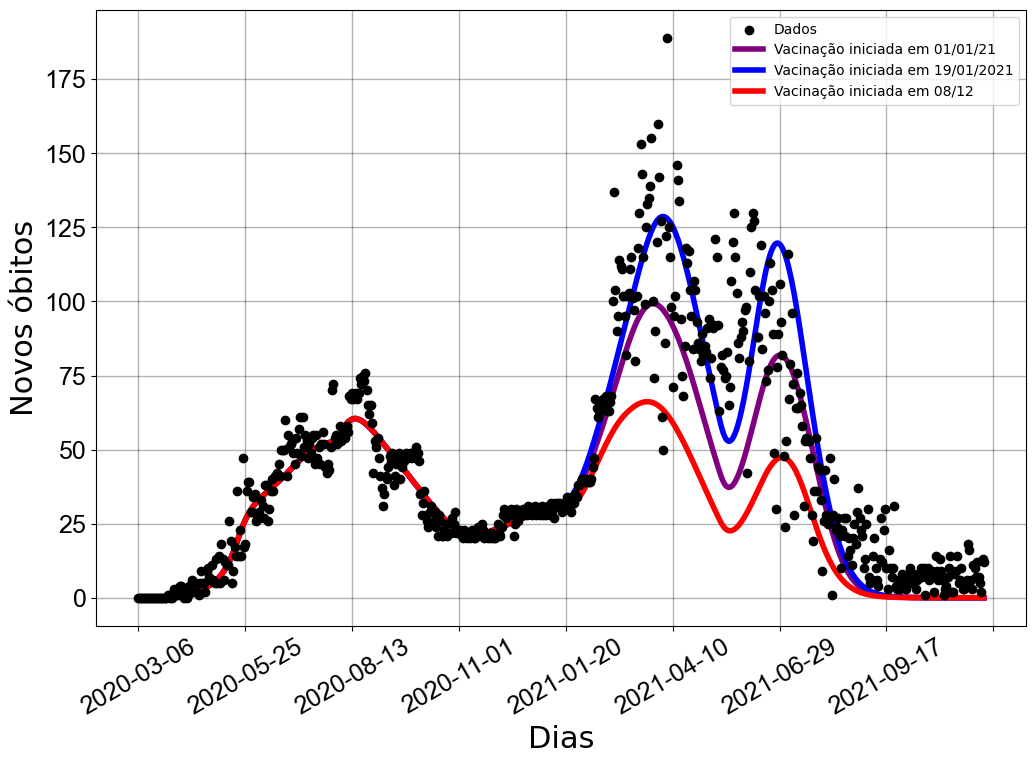

In [12]:
N = 14873064

mortes_resultados_adiantado = resultados_adiantado.y[-3, :] #mortes acumulados
mortes_resultados_normal = resultados_normais.y[-3, :] #mortes acumulados
mortes_resultado_muito_adiantado = resultados_muito_adiantados.y[-3, :]

#Criando plot
fig, (ax) = pl.subplots(figsize=(12,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

# Taxa de mortos - dados
taxa_mortos_dados = np.diff(mortos_dados)
ax.scatter(datas[:len(taxa_mortos_dados)], taxa_mortos_dados, color='black', zorder=3, label='Dados')

# Taxa de mortos - modelo
taxa_mortos_modelo_adiantado = np.diff(N*mortes_resultados_adiantado)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_mortos_modelo_adiantado)], taxa_mortos_modelo_adiantado, color='purple',label='Vacinação iniciada em 01/01/21', linewidth=4)

# Taxa de mortos - modelo
taxa_mortos_modelo_normal = np.diff(N*mortes_resultados_normal)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_mortos_modelo_normal)], taxa_mortos_modelo_normal, color='blue',label='Vacinação iniciada em 19/01/2021', linewidth=4)

# Taxa de mortos - modelo
taxa_mortos_modelo_muito_adiantado = np.diff(N*mortes_resultado_muito_adiantado)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_mortos_modelo_muito_adiantado)], taxa_mortos_modelo_muito_adiantado, color='red',label='Vacinação iniciada em 08/12', linewidth=4)

ax.autoscale()

#Set the labels
ax.set_ylabel('Novos óbitos',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)

#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  
pl.legend()
#Show Graph       
pl.show()


In [13]:
# df = pd.DataFrame(mortes_resultados_adiantado)
# df.to_csv('Antecipacao/mortes_resultados_adiantado.csv', index=False)
# df = pd.DataFrame(mortes_resultados_normal)
# df.to_csv('Antecipacao/mortes_resultados_normal.csv', index=False)
# df = pd.DataFrame(mortes_resultado_muito_adiantado)
# df.to_csv('Antecipacao/mortes_resultado_muito_adiantado.csv', index=False)

## Casos

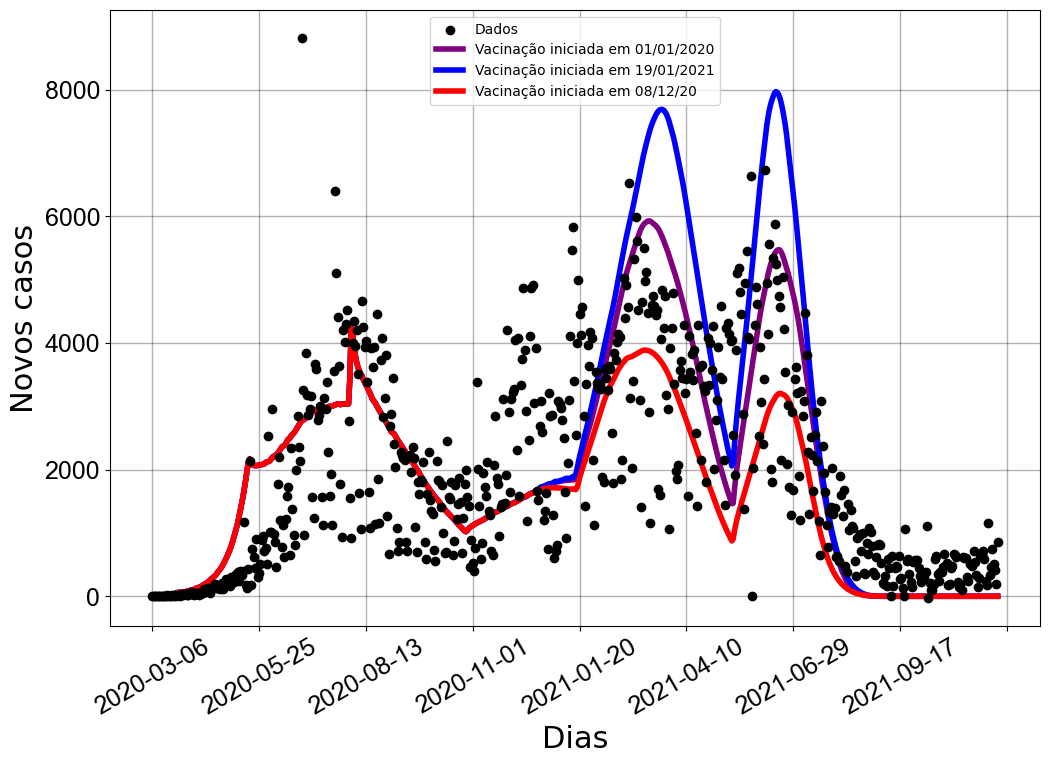

In [14]:
N = 14873064

casos_resultados_adiantados = resultados_adiantado.y[-2, :] #mortes acumulados
casos_resultados_normais = resultados_normais.y[-2, :] #mortes acumulados
casos_resultados_muito_adiantados = resultados_muito_adiantados.y[-2, :] #mortes acumulados

#Criando plot
fig, ax = pl.subplots(figsize=(12,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

# Taxa de mortos - dados
taxa_casos_dados = np.diff(casos_dados)
ax.scatter(datas[:len(taxa_casos_dados)], taxa_casos_dados, color='black', zorder=3, label='Dados')

# Taxa de mortos - modelo
taxa_casos_adiantados = np.diff(N*casos_resultados_adiantados)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_casos_adiantados)], taxa_casos_adiantados, color='purple',label='Vacinação iniciada em 01/01/2020', linewidth=4)

# Taxa de mortos - modelo
taxa_casos_modelo_normal = np.diff(N*casos_resultados_normais)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_casos_modelo_normal)], taxa_casos_modelo_normal, color='blue',label='Vacinação iniciada em 19/01/2021', linewidth=4)

# Taxa de mortos - modelo
taxa_casos_modelo_muito_adiantado = np.diff(N*casos_resultados_muito_adiantados)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_casos_modelo_muito_adiantado)], taxa_casos_modelo_muito_adiantado, color='red',label='Vacinação iniciada em 08/12/20', linewidth=4)


ax.autoscale()

#Set the labels
ax.set_ylabel('Novos casos',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  
pl.legend()
#Show Graph       
pl.show()
